# **ENV590.05 - Econ of Modern Power Systems - M6 - Residential PV + battery system management model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

## Installing and Running Pyomo on Google Colab

To import/install a library that's not in Colaboratory by default, you can use !pip install. This needs to be done at the begining of you notebook. And you only need to run it once at the start of each Colab session.

In [ ]:
!pip install pyomo

## Installing optimization solver

Pyomo does not include any optimization solvers. Therefore, you will need to install third-party solvers to solve optimization models built with Pyomo. There are several solver options, for this class we will use glpk.
We'll install glpk using apt-get.

In [ ]:
!apt-get install -y -qq glpk-utils

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

## Import Pyomo and solver

The first step in any Pyomo project is to import relevant components of the Pyomo library. This can be done with the following python statement 'from pyomo.environ import *'. \\

We use the * symbol to elimate the need of using the expression pyomo.environ every time we need to use a pyomo function. \\

You also need to load the solver. The Pyomo libary includes a SolverFactory() class used to specify a solver. Here we will use
**glpk** which works for linear problems, put **cbc** from coin OR could be used for nonlinear applications.

In [ ]:
from pyomo.environ import *
#Import solver
opt=SolverFactory('glpk')

## Importing Case Study data set


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
storage = pd.read_csv("Pdata.csv")
storage.columns = ["Time", "P_PV", "PLoad", "C_t"] #P_PV_t = PV generation, C_t = electricity rate
storage.head(24)

,Time,P_PV,PLoad,C_t
0,"Sep 18, 12:00 am",0.000000,2.05,0.099964
1,"Sep 18, 1:00 am",0.000000,0.32,0.099964
2,"Sep 18, 2:00 am",0.000000,1.72,0.099964
3,"Sep 18, 3:00 am",0.000000,0.34,0.099964
4,"Sep 18, 4:00 am",0.000000,1.58,0.099964
5,"Sep 18, 5:00 am",0.000000,0.34,0.099964
6,"Sep 18, 6:00 am",0.230828,0.83,0.099964
7,"Sep 18, 7:00 am",1.532470,1.55,0.099964
8,"Sep 18, 8:00 am",3.199970,0.51,0.099964
9,"Sep 18, 9:00 am",4.539360,1.98,0.099964


## Create Model with vectors and numpy

In [ ]:
#Creating model
model = ConcreteModel()

In [ ]:
T=range(24)  #set of hours
P_PV = storage.loc[:,"P_PV"]
P_load = storage.loc[:,"PLoad"]
C = storage.loc[:,"C_t"]
SOC_0 = 0.2
Eff = 0.92
StoCap = 4

In [ ]:
model.Pgrid = Var(T, domain = NonNegativeReals)  #Pgrid
model.Pch = Var(T, domain = NonNegativeReals, bounds = (0,3))    #Pcharge
model.Pdisch = Var(T, domain = NonNegativeReals, bounds = (0,3)) #Pdischarge
model.Pslack = Var(T, domain = NonNegativeReals) #Pslack
model.SOC = Var(T, domain = NonNegativeReals, bounds = (0.2,0.8))  #State of charge

In [ ]:
#Adding objective function
model.cost_func = Objective(expr = sum(model.Pgrid[t] * C[t] for t in T), sense = minimize)

In [ ]:
#Adding constraints
model.constraints = ConstraintList()

for t in T:
  #power balance
  model.constraints.add(model.Pgrid[t] - model.Pch[t] + model.Pdisch[t] - model.Pslack[t] == P_load[t] - P_PV[t])

  #charge balance
  if (t==0):
    model.constraints.add(model.SOC[t] == SOC_0 + (Eff/StoCap)*model.Pch[t] - 1/(Eff * StoCap)*model.Pdisch[t] )
  else:
    model.constraints.add(model.SOC[t] == model.SOC[t-1] + (Eff/StoCap)*model.Pch[t] - 1/(Eff * StoCap)*model.Pdisch[t] )

  #storage only charging from PV
  model.constraints.add(model.Pch[t] <= P_PV[t])

  #storage only discharging to supply house demand/load
  model.constraints.add(model.Pdisch[t] <= P_load[t])


In [ ]:
#Solve Model
opt.solve(model)

print("Cost =", model.cost_func())
print("\n")

Cost = 1.996216189827944




Since we didn't go over how to generate plots in Python, I will provide the code that will get the decision variables value, store in a data frame and then generate plots to visualize the results.

Let's start by creating a data frame with the value of all decision variables for the 24 hours of the day.

In [ ]:
sys_op_sch = pd.DataFrame(np.zeros((24,6)))

for t in T:
  sys_op_sch.iloc[t,0] = t+1
  sys_op_sch.iloc[t,1] =  model.Pgrid[t].value
  sys_op_sch.iloc[t,2] =  model.Pch[t].value
  sys_op_sch.iloc[t,3] =  model.Pdisch[t].value
  sys_op_sch.iloc[t,4] =  model.Pslack[t].value
  sys_op_sch.iloc[t,5] =  model.SOC[t].value

sys_op_sch = sys_op_sch.rename(columns={0:"Hour",1:"Pgrid",2:"Pcharge",3:"Pdischarge",4:"Pslack",5:"SOC"})
print(sys_op_sch)


    Hour     Pgrid   Pcharge  Pdischarge    Pslack       SOC
0    1.0  2.050000  0.000000     0.00000  0.000000  0.200000
1    2.0  0.320000  0.000000     0.00000  0.000000  0.200000
2    3.0  1.720000  0.000000     0.00000  0.000000  0.200000
3    4.0  0.340000  0.000000     0.00000  0.000000  0.200000
4    5.0  1.580000  0.000000     0.00000  0.000000  0.200000
5    6.0  0.340000  0.000000     0.00000  0.000000  0.200000
6    7.0  0.599172  0.000000     0.00000  0.000000  0.200000
7    8.0  0.017530  0.000000     0.00000  0.000000  0.200000
8    9.0  0.000000  0.000000     0.00000  2.689970  0.200000
9   10.0  0.000000  0.497483     0.00000  2.061877  0.314421
10  11.0  0.000000  0.000000     0.00000  3.957650  0.314421
11  12.0  0.000000  0.000000     0.42107  0.000000  0.200000
12  13.0  0.000000  0.000000     0.00000  1.747060  0.200000
13  14.0  0.000000  0.000000     0.00000  3.685510  0.200000
14  15.0  0.000000  1.108786     0.00000  0.264374  0.455021
15  16.0  0.000000  1.49

The ggplot will automatically plot all columns in the same graph and add a legend as long as you gather the data frame as shown in the code below. Note that we just stacked the columns.

In [ ]:
sys_op_sch_gather=sys_op_sch.melt(id_vars=["Hour"])
sys_op_sch_gather.head(30)

,Hour,variable,value
0,1.0,Pgrid,2.050000
1,2.0,Pgrid,0.320000
2,3.0,Pgrid,1.720000
3,4.0,Pgrid,0.340000
4,5.0,Pgrid,1.580000
5,6.0,Pgrid,0.340000
6,7.0,Pgrid,0.599172
7,8.0,Pgrid,0.017530
8,9.0,Pgrid,0.000000
9,10.0,Pgrid,0.000000


Now we have a data frame ready to be used by ggplot. All we have to do is create the plot.

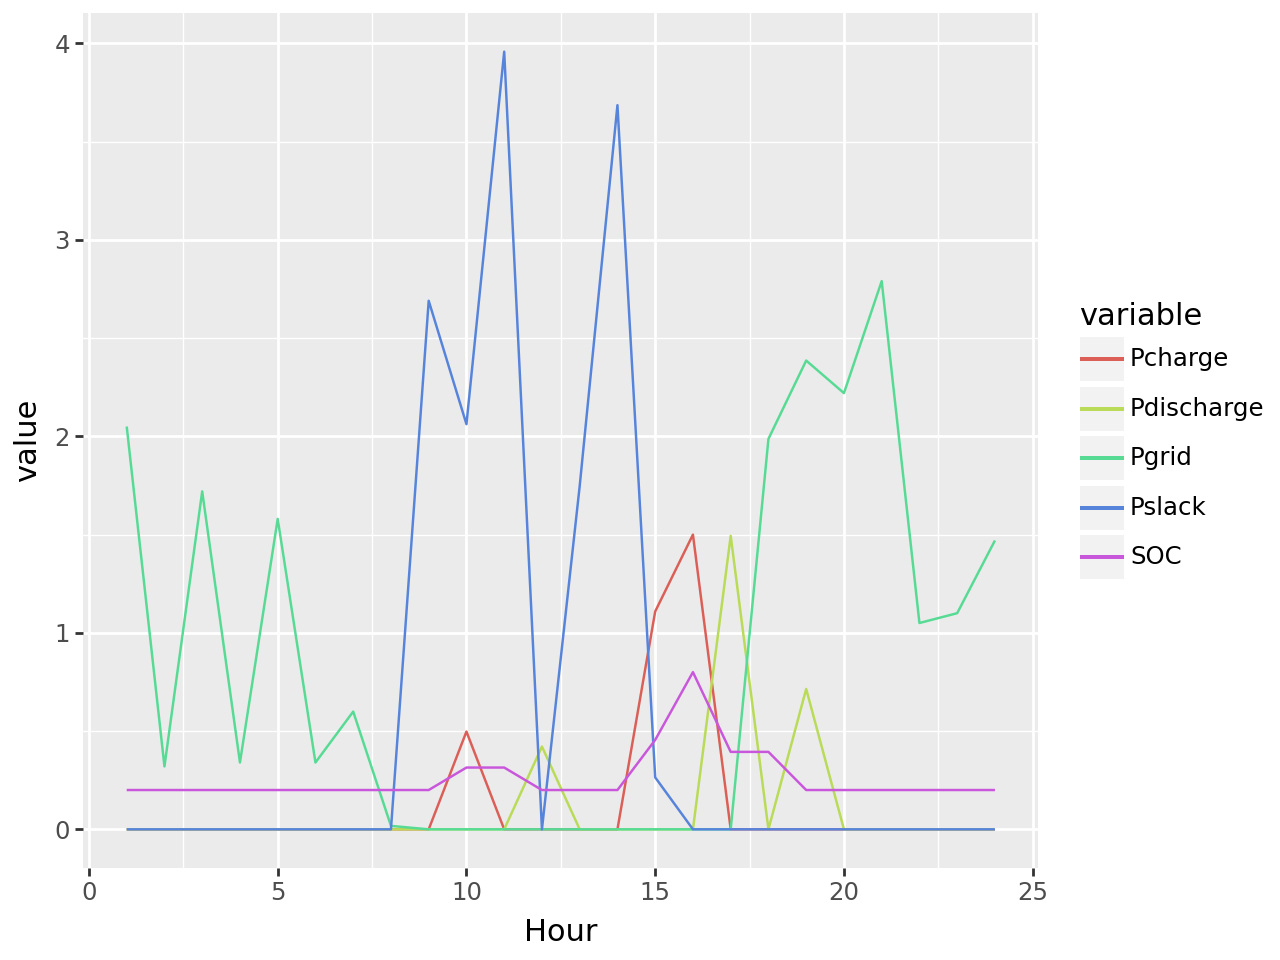

In [ ]:
#Create plot with ggplot from library plotnine
from plotnine import ggplot, aes, geom_line, geom_bar

#print(filtered_data)
plot = (
    ggplot(sys_op_sch_gather,aes(x="Hour",y="value",color="variable"))
    + geom_line()
    #+ geom_bar(stat="identity",position="dodge")
)
plot.show()